In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class CNN(nn.Module):
    def __init__(self):

        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3,padding=1)
        self.fc1 = nn.Linear(7*7*32, 100)
        self.fc2 = nn.Linear(100, 10)
        self.drop_layer = nn.Dropout(p=0.2)

    def last_hidden_layer_output(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.drop_layer(F.relu(self.conv3(x)))
        x = self.drop_layer(F.relu(self.conv4(x)))
        x = x.view(-1, 7*7*32)
        x = F.relu(self.fc1(x))
        return x

    def forward(self, x):
        x = self.last_hidden_layer_output(x)
        x = self.fc2(x)
        return x

In [4]:
model_cnn = CNN()
model_cnn = model_cnn.to(device)

In [5]:
batch_size = 128

mnist_train = datasets.MNIST("data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("data", train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 396098732.36it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44017330.60it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 179796994.58it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21722381.72it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.002

optimizer = optim.Adam(model_cnn.parameters(), lr=learning_rate)

In [7]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 2 every 10 epochs"""
    lr = learning_rate * (0.5 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [8]:

def train(model, train_dataloader):

    model = model.to(device)
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0

    for data, target in train_dataloader:

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct / len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')

    return train_loss, train_accuracy

In [9]:
# validation function
def test(model, test_dataloader):
    model = model.to(device)
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0

    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()

    val_loss = val_running_loss / len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct / len(test_dataloader.dataset)

    return val_loss, val_accuracy

In [10]:
print("BEGIN TRAINING")

train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

for epoch in range(15):

    adjust_learning_rate(optimizer, epoch)
    train_epoch_loss, train_epoch_accuracy = train(model_cnn, train_loader)
    val_epoch_loss, val_epoch_accuracy = test(model_cnn, test_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)


torch.save(model_cnn.state_dict(), "model_cnn_mnist_digit.pt")

print("done")

BEGIN TRAINING
Train Loss: 0.0023, Train Acc: 90.48
Train Loss: 0.0006, Train Acc: 97.53
Train Loss: 0.0005, Train Acc: 98.12
Train Loss: 0.0004, Train Acc: 98.52
Train Loss: 0.0003, Train Acc: 98.67
Train Loss: 0.0003, Train Acc: 98.83
Train Loss: 0.0003, Train Acc: 98.99
Train Loss: 0.0002, Train Acc: 98.97
Train Loss: 0.0002, Train Acc: 99.10
Train Loss: 0.0002, Train Acc: 99.16
Train Loss: 0.0001, Train Acc: 99.44
Train Loss: 0.0001, Train Acc: 99.55
Train Loss: 0.0001, Train Acc: 99.59
Train Loss: 0.0001, Train Acc: 99.58
Train Loss: 0.0001, Train Acc: 99.60
done


validation error
0.0082


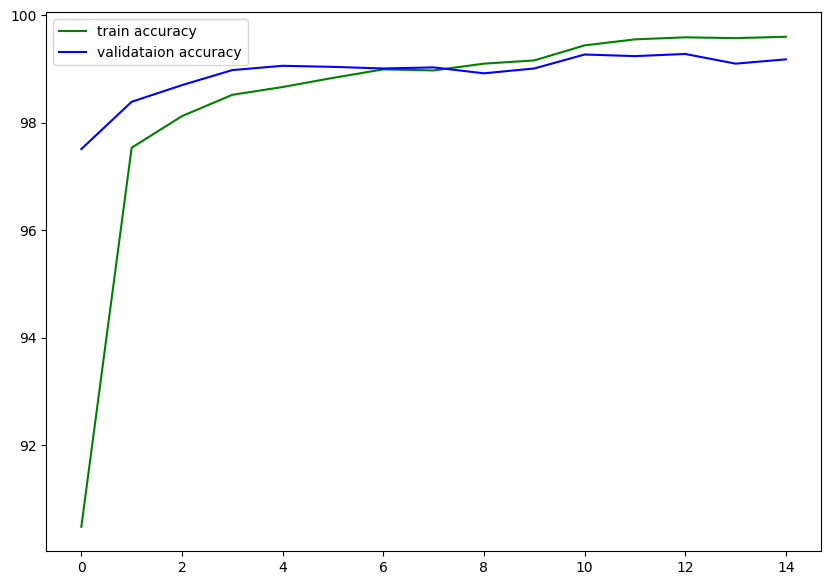

In [11]:

model_cnn = CNN()

model_cnn.load_state_dict(torch.load("model_cnn_mnist_digit.pt"))
model_cnn.eval()
model_cnn = model_cnn.to(device)

total_loss, total_err = 0., 0.

for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    yp = model_cnn(X)

    total_err += (yp.max(dim=1)[1] != y).sum().item()

print("validation error")
print(total_err / len(test_loader.dataset))

plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

In [12]:
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

In [13]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

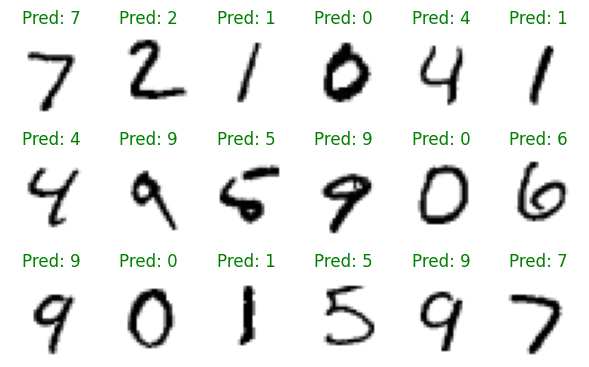

In [14]:
yp = model_cnn(X)
plot_images(X, y, yp, 3, 6)

In [15]:
test_loader2 = DataLoader(mnist_test, batch_size=2000, shuffle=False)

In [16]:
for X,y in test_loader2:
    X,y = X.to(device), y.to(device)
    break

In [17]:
model_cnn.eval()

with torch.no_grad():
    output = model_cnn(X)

pred_original = output.data.max(1, keepdim=True)[1]
pred_original = pred_original.view_as(y)

inds_not_correct = np.where(pred_original.cpu() != y.cpu())[0]

X = X[inds_not_correct]
y = y[inds_not_correct]

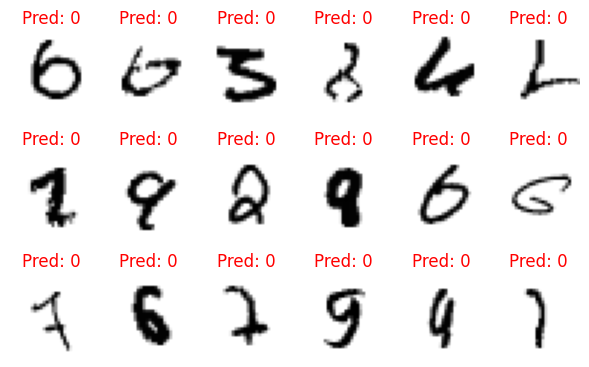

In [18]:
yp=torch.max(model_cnn(X).data, 1)[1]


plot_images(X, y, yp, 3, 6)